# 50.038 Computational Data Science project

Group members:<br />Kenny Ong Ker Chin 1005290 <br />Jobelle Lee Ern Ee 1005547<br />Baarath S/O Sellathurai 1005433

## Problem

The problem is to predict the prices of public housing units in Singapore based on their characteristics. This will help potential buyers and sellers to make informed decisions about the market value of their properties.

## Dataset

The Housing and Development Board provides data on the resale price of the flats as well as relevant data that might impact these prices.<br />
Coverage of the data is from January 1, 2017 to March 5, 2023.<br />
The dataset includes information on the location, type, size, and age of the units. <a href='https://data.gov.sg/dataset/resale-flat-prices'>https://data.gov.sg/dataset/resale-flat-prices</a>

In [258]:
# Importing the libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")

# Resale Flat Prices data
url = "https://data.gov.sg/api/action/datastore_search?resource_id=f1765b54-a209-4718-8d38-a39237f502b3"

<h1>Data Visualization</h1>

In [259]:
# Methods to get data from API
def searchData(url, keyword):
    results = pd.DataFrame()
    data = requests.get(f"{url}&q={keyword}").json()
    results.append(data['result']['records'])
    
    while data['result']['_links']['next']:
        data = requests.get("https://data.gov.sg/" + data['result']['_links']['next']).json()
        results.append(data['result']['records'])

    return results

def limitData(url, limitNum):
    data = requests.get(f"{url}&limit={limitNum}").json()
    return data['result']['records']


In [260]:
df = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv") # OR USE searchData/limitData
df = df.drop_duplicates()
print(df.dtypes)
df.head(2)

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0


In [261]:
df['year'] = df['month'].apply(lambda x: x.split('-')[0]).astype(int)
df['month'] = df['month'].apply(lambda x: x.split('-')[1]).astype(int)

# Convert remaining lease from years to months
df['month_remaining_lease'] = df['remaining_lease'].apply(lambda x: int(x.split(' ')[0]) * 12 + int(x.split(' ')[2]) if len(x.split(' ')) > 2 else int(x.split(' ')[0]) * 12)

# Split storey range into min and max
df['storey_range_low'] = df['storey_range'].apply(lambda x: int(x.split('TO')[0]))
df['storey_range_high'] = df['storey_range'].apply(lambda x: int(x.split('TO')[1]))

# Convert categorical columns to numerical
df['flat_model'] = df['flat_model'].astype('category').cat.codes

df.head(5)

,month,year,town,flat_type,floor_area_sqm,lease_commence_date,month_remaining_lease,flat_model,storey_range_low,storey_range_high,resale_price
0,1,2017,ANG MO KIO,2 ROOM,44.0,1979,736,5,10,12,232000.0
1,1,2017,ANG MO KIO,3 ROOM,67.0,1978,727,12,1,3,250000.0
2,1,2017,ANG MO KIO,3 ROOM,67.0,1980,749,12,1,3,262000.0
3,1,2017,ANG MO KIO,3 ROOM,68.0,1980,745,12,4,6,265000.0
4,1,2017,ANG MO KIO,3 ROOM,67.0,1980,749,12,1,3,265000.0


In [262]:
# Set up the matplotlib figure
sns.set_style('whitegrid')

                          month  floor_area_sqm  flat_model  \
month                  1.000000        0.004697   -0.008086   
floor_area_sqm         0.004697        1.000000   -0.353089   
flat_model            -0.008086       -0.353089    1.000000   
lease_commence_date    0.009307        0.135443   -0.119049   
resale_price           0.006426        0.612586   -0.237218   
year                  -0.109528       -0.014882   -0.012993   
month_remaining_lease  0.002777        0.139582   -0.119422   
storey_range_low      -0.003247       -0.011056   -0.041560   
storey_range_high     -0.003247       -0.011056   -0.041560   

                       lease_commence_date  resale_price      year  \
month                             0.009307      0.006426 -0.109528   
floor_area_sqm                    0.135443      0.612586 -0.014882   
flat_model                       -0.119049     -0.237218 -0.012993   
lease_commence_date               1.000000      0.359569  0.124814   
resale_price       

<AxesSubplot:>

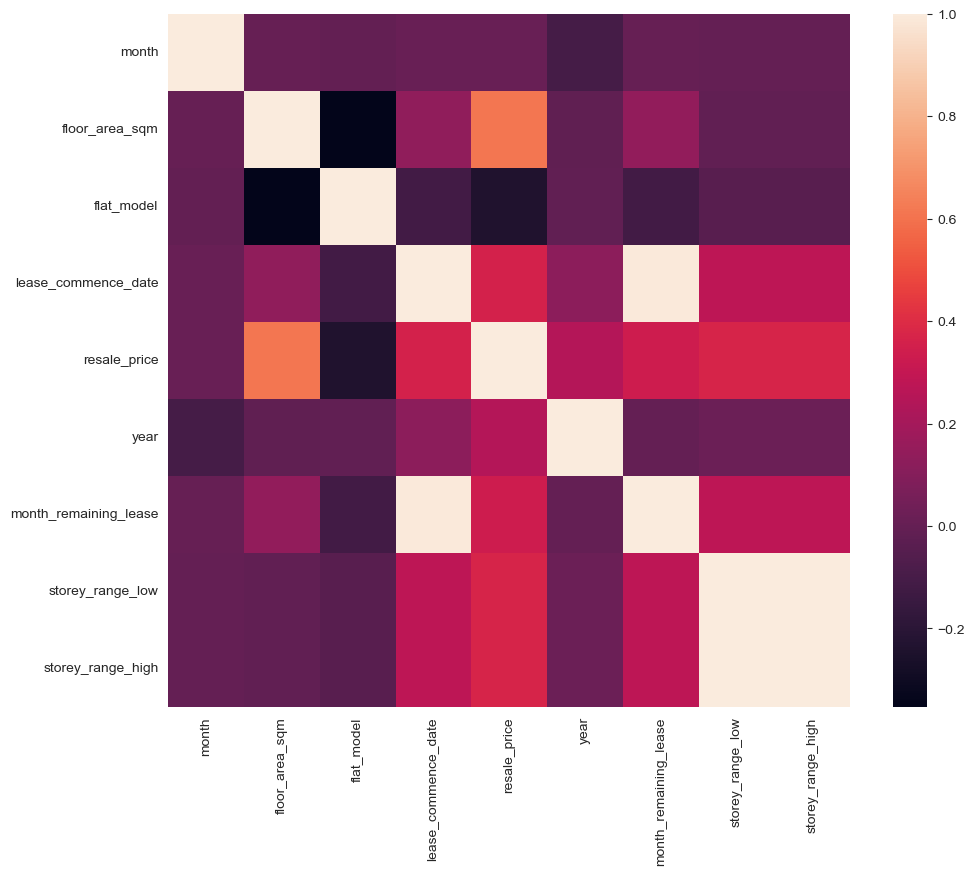

In [263]:
# Compute the correlation matrix
corr = df.corr()
print(corr)

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df.corr())

### Analyzing Categorical Column: town

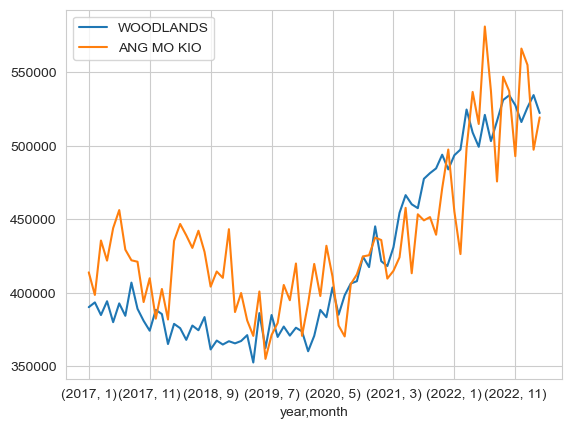

In [264]:
# for each month and year, plot the mean price into line chart with legend
def query_mean_plot_by_town(town):
    df[df['town'] == town].groupby(['year', 'month']).mean()['resale_price'].plot(label=town)
    plt.legend()
    
query_mean_plot_by_town('WOODLANDS')
query_mean_plot_by_town('ANG MO KIO')

<AxesSubplot:title={'center':'Town'}>

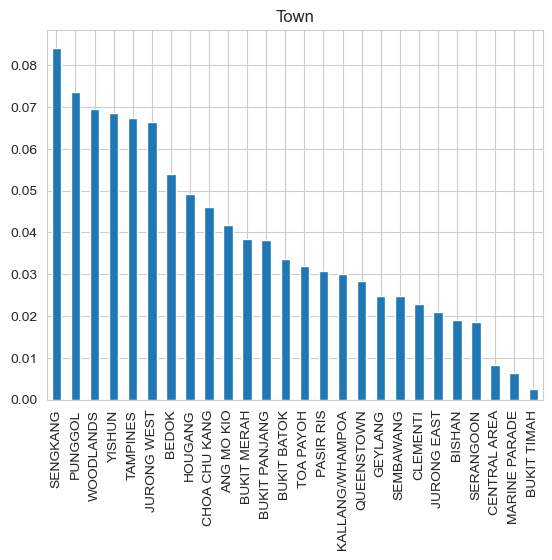

In [265]:
df.town.value_counts(normalize=True).plot(kind='bar', title='Town')

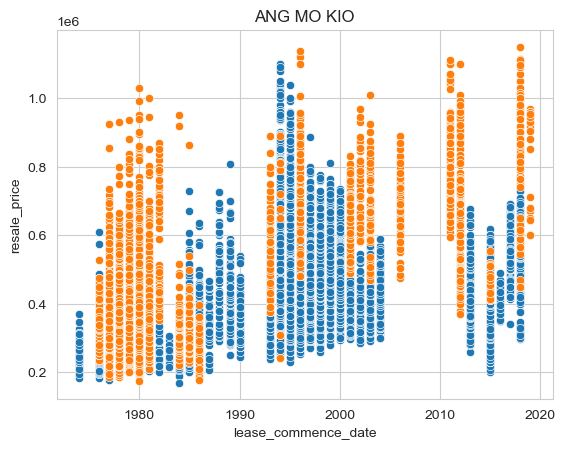

In [266]:
# For each town, plot lease_commence_date against resale price
def plot_date_agst_price(town):
    sns.scatterplot(x='lease_commence_date', y='resale_price', data=df[df['town'] == town])
    plt.title(town)
    

plot_date_agst_price('WOODLANDS')
plot_date_agst_price('ANG MO KIO')

### Analyzing Categorical Column: flat_type

<AxesSubplot:title={'center':'Flat Type'}>

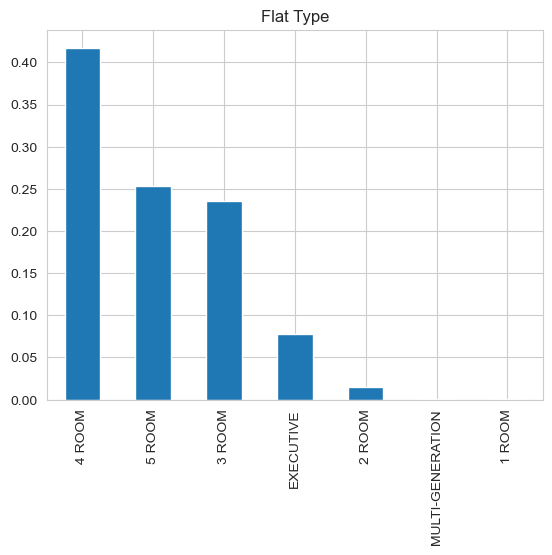

In [267]:
df.flat_type.value_counts(normalize=True).plot(kind='bar', title='Flat Type')

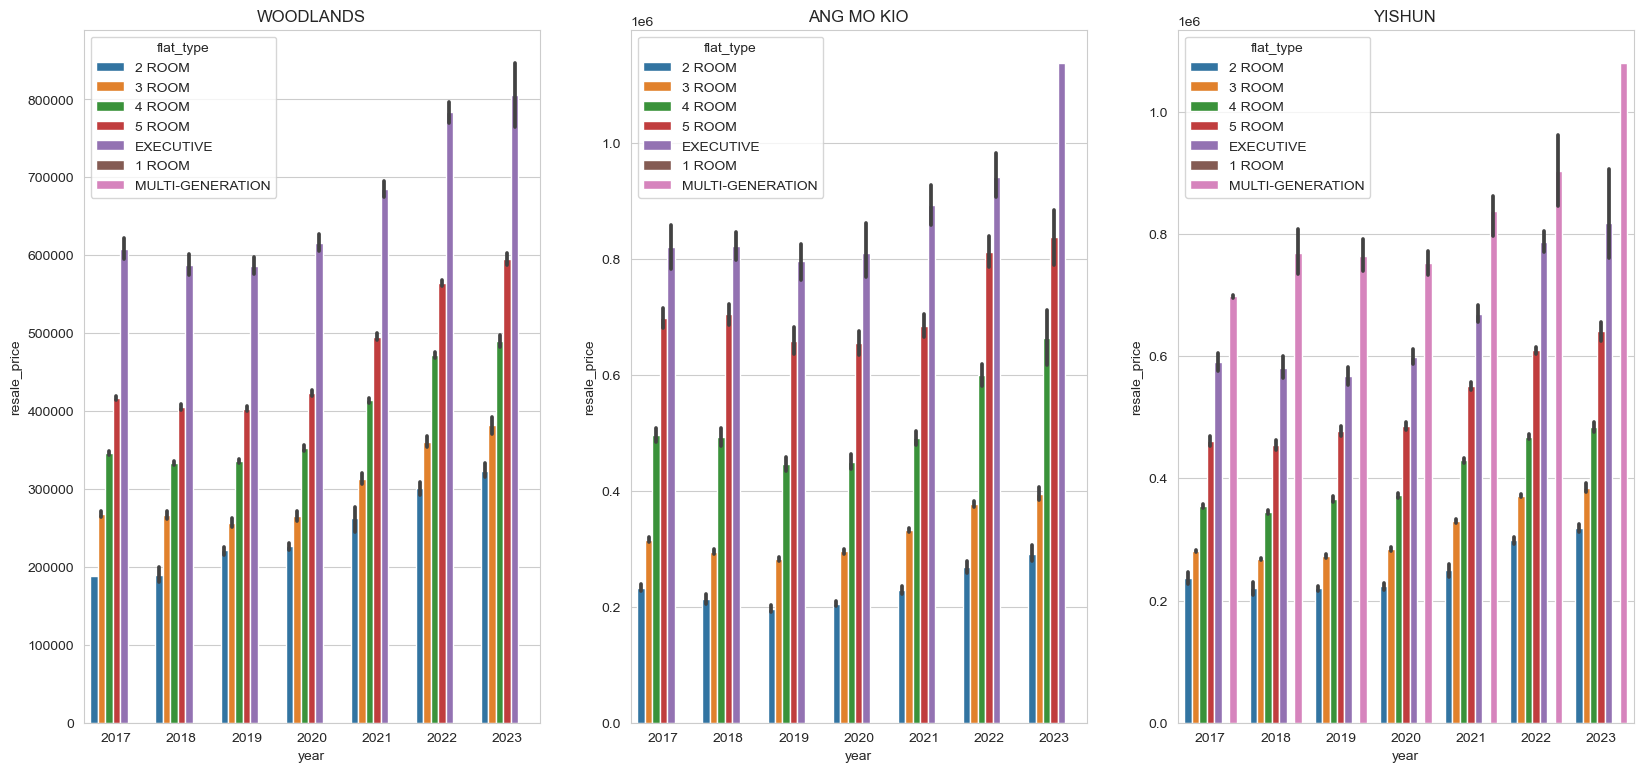

In [268]:
f, ax = plt.subplots(figsize=(20, 9))

def plot_year_against_price(town):
    sns.barplot(data=df[df['town'] == town], x="year", y="resale_price", hue="flat_type", hue_order=df.flat_type.unique())
    plt.title(town)
        
plt.subplot(131)
plot_year_against_price('WOODLANDS')
plt.subplot(132)
plot_year_against_price('ANG MO KIO')
plt.subplot(133)
plot_year_against_price('YISHUN')
    

### Line Plots of Continuous Variables

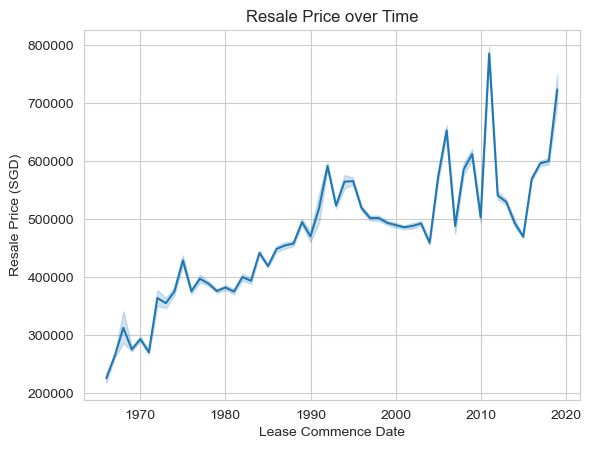

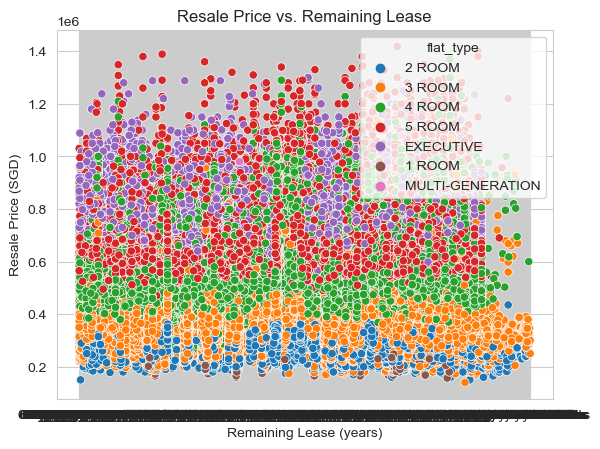

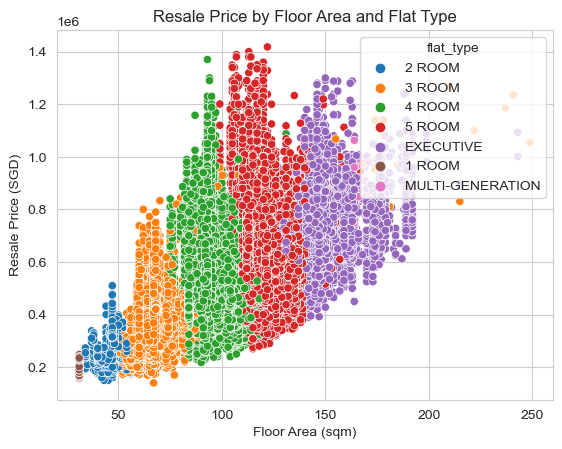

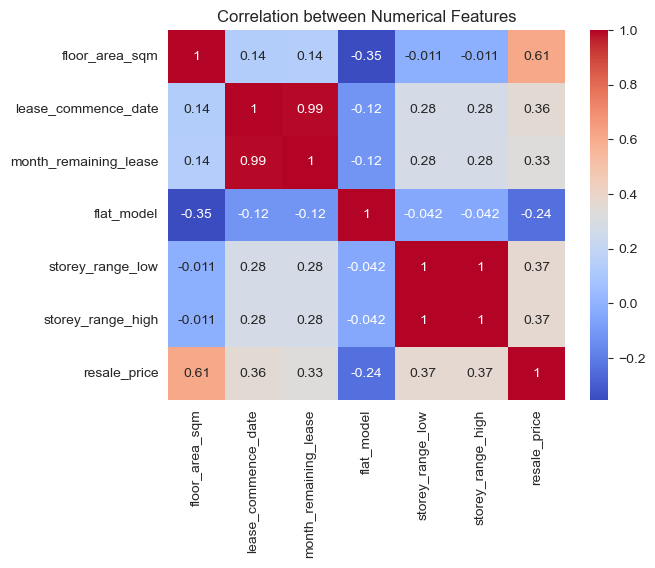

In [269]:
# line plot of lease commence date and resale price
sns.lineplot(x='lease_commence_date', y='resale_price', data=df)
plt.title('Resale Price over Time')
plt.xlabel('Lease Commence Date')
plt.ylabel('Resale Price (SGD)')
plt.show()

# scatter plot of remaining lease and resale price
sns.scatterplot(x='remaining_lease', y='resale_price', hue='flat_type', data=df)
plt.title('Resale Price vs. Remaining Lease')
plt.xlabel('Remaining Lease (years)')
plt.ylabel('Resale Price (SGD)')
plt.show()

# scatter plot of floor area vs. resale price, colored by flat type
sns.scatterplot(x='floor_area_sqm', y='resale_price', hue='flat_type', data=df)
plt.title('Resale Price by Floor Area and Flat Type')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price (SGD)')
plt.show()

# heatmap of correlation between numerical features
corr = df[['floor_area_sqm', 'lease_commence_date', 'month_remaining_lease', 'flat_model', 'storey_range_low', 'storey_range_high', 'resale_price']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between Numerical Features')
plt.show()

<h1>Algorithm</h1>

## Regressors Used

1. Decision Tree Regressor

- Mimic human decision-making and can therefore be used in a variety of business settings
- Can be used to compare the costs and likely values of decision pathways that a business might take (future outcomes)
- Benefits: Intuitive, Informational, Scaling

Link: https://www.keboola.com/blog/decision-trees-machine-learning

2. Random Forest Regressor

- Supervised learning algorithm (Learns the mappings between inputs and outputs) and ensemble algorithm (Combine multiple other machine learning algorithms)
- Used to predict continuous values - E.g. Predict future prices/costs, predict future revenue, compare performance
- Benefits: High accuracy, Scalability, Interpretable, Easy to use

Link: https://www.keboola.com/blog/random-forest-regression

3. Gradient Boosting Algorithm

- Used to minimize bias error of the model
- Can be used for predicting not only continuous target variable (as a Regressor) but also categorical target variable (as a Classifier) - In regression problems, the cost function is MSE whereas, in classification problems, the cost function is Log-Loss
- Generally used to decrease the Bias error - The algorithm uses gradient descent to minimize the loss.

Link: https://www.analyticsvidhya.com/blog/2021/04/how-the-gradient-boosting-algorithm-works/; https://blog.paperspace.com/implementing-gradient-boosting-regression-python/



In [270]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [271]:
class PredictionModel:
    def __init__(self, regressor_type):
        self.features = ['floor_area_sqm', 'lease_commence_date', 'month_remaining_lease', 'flat_model', 'storey_range_low', 'storey_range_high']
        self.y_col = 'resale_price'
        self.regressor_type = regressor_type
    
    def train_model(self, final_df, town, flat_type):
        target_df = final_df[(final_df['town'] == town) & (final_df['flat_type'] == flat_type)]
        y = target_df[self.y_col]
        X = target_df[self.features]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # train using categorical data
        
        return True

    def fit(self):
        if self.regressor_type == "DecisionTreeRegressor":
            regressor = DecisionTreeRegressor(random_state=46)
        elif self.regressor_type == "RandomForestRegressor":
            regressor = RandomForestRegressor(n_estimators=100, random_state=48)
        elif self.regressor_type == "GradientBoostingRegressor":
            regressor = GradientBoostingRegressor()

        return regressor.fit(self.X_train, self.y_train)
    
    def predict(self, regressor):
        return regressor.predict(self.X_test)

    def evaluate(self, y_pred):
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        print("Mean Squared Error: {:.4f}".format(rmse))
        r2 = r2_score(self.y_test, y_pred)
        print("R2 score: {}".format(r2))
        
        plt.figure(figsize=(7,4))
        plt.scatter(self.y_test, y_pred, c='crimson')
        plt.yscale('log')
        plt.xscale('log')

        p1 = max(max(y_pred), max(self.y_test))
        p2 = min(min(y_pred), min(self.y_test))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('True Values', fontsize=15)
        plt.ylabel('Predictions', fontsize=15)
        plt.axis('equal')
        plt.show()

    
    def plot_importance(self, regressor):
        fig, ax = plt.subplots(figsize=(7, 4))
        importances = pd.Series(data=regressor.feature_importances_, index=self.X_train.columns)
        importances_sorted = importances.sort_values()
        importances_sorted.plot(kind='barh', color='lightgreen')
        plt.title('Features Importances')
        plt.show()
    
    
    def plot_permutation(self, regressor):
        fig, ax = plt.subplots(figsize=(7, 4))
        result = permutation_importance(regressor, self.X_test, self.y_test, n_repeats=10, random_state=42, n_jobs=2)
        sorted_idx = result.importances_mean.argsort()
        plt.boxplot(
            result.importances[sorted_idx].T,
            vert=False,
            labels=np.array(self.features)[sorted_idx],
        )
        plt.title("Permutation Importance (test set)")
        plt.show()

WOODLANDS - 4 ROOM
Mean Squared Error: 27623.9129
R2 score: 0.8601224896416195


<Figure size 600x600 with 0 Axes>

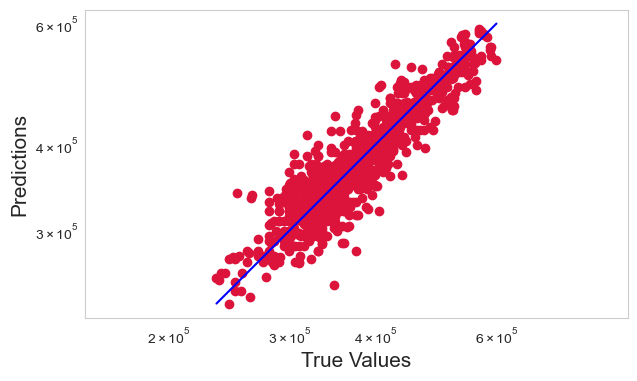

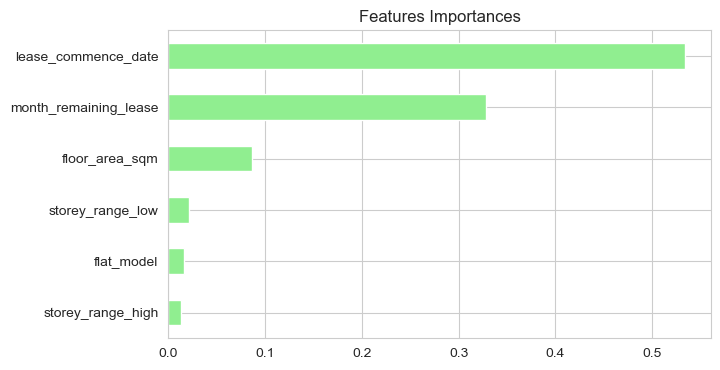

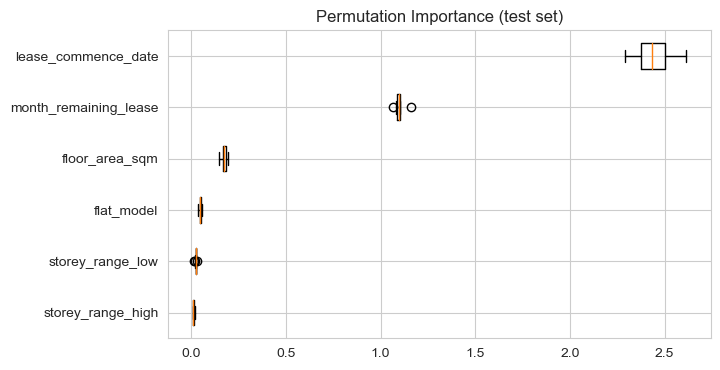

In [272]:
town = 'WOODLANDS'
flat_type = '4 ROOM'

fig = plt.figure(figsize=(6, 6))
# Decision Tree Regressor
print(town, "-", flat_type)
decision_tree_model = PredictionModel('DecisionTreeRegressor')
decision_tree_model.train_model(df.copy(), town, flat_type)
decision_tree_regressor = decision_tree_model.fit()
y_pred = decision_tree_model.predict(decision_tree_regressor)
decision_tree_model.evaluate(y_pred)
decision_tree_model.plot_importance(decision_tree_regressor)
decision_tree_model.plot_permutation(decision_tree_regressor)

WOODLANDS - 4 ROOM
Mean Squared Error: 22240.0680
R2 score: 0.9093329004963958


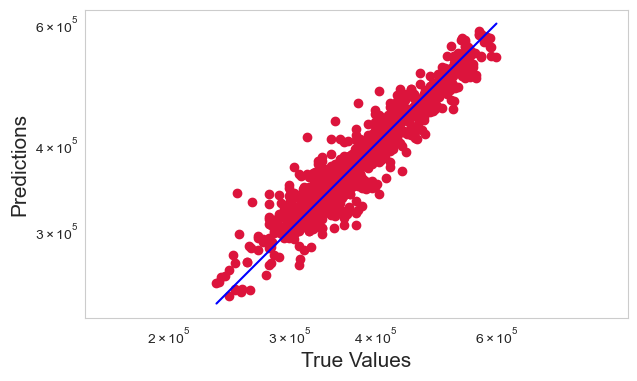

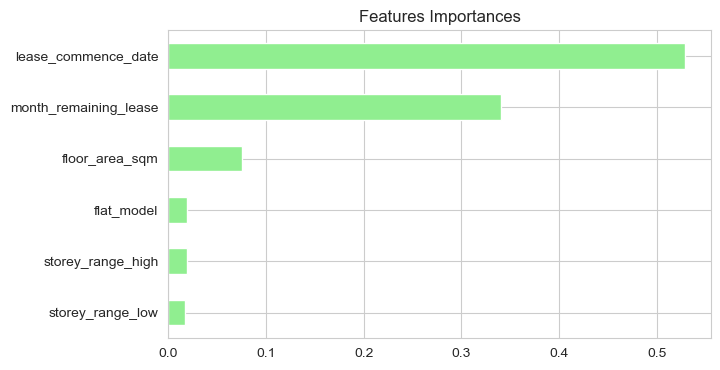

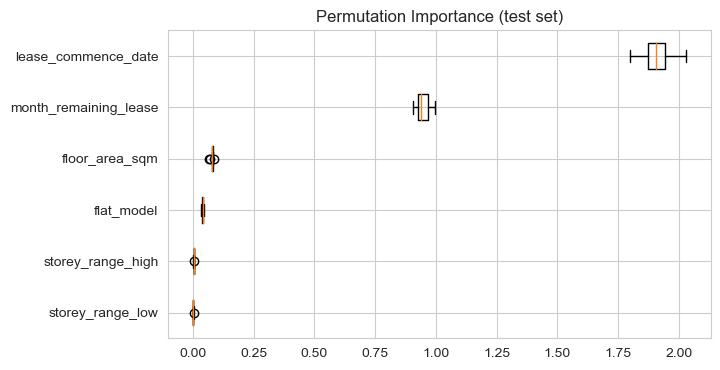

In [273]:
# Random Forest Regressor
print(town, "-", flat_type)
random_forest_model = PredictionModel('RandomForestRegressor')
random_forest_model.train_model(df.copy(), town, flat_type)
random_forest_regressor = random_forest_model.fit()
y_pred = random_forest_model.predict(random_forest_regressor)
random_forest_model.evaluate(y_pred)
random_forest_model.plot_importance(random_forest_regressor)
random_forest_model.plot_permutation(random_forest_regressor)

WOODLANDS - 4 ROOM
Mean Squared Error: 27356.1823
R2 score: 0.8628207326395988


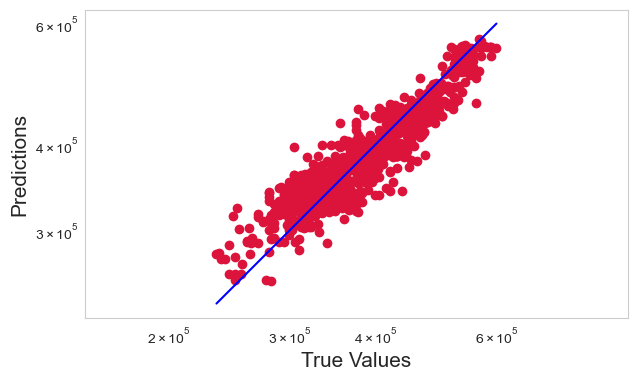

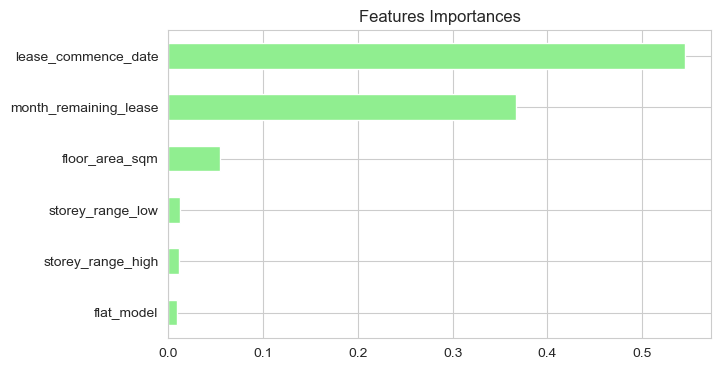

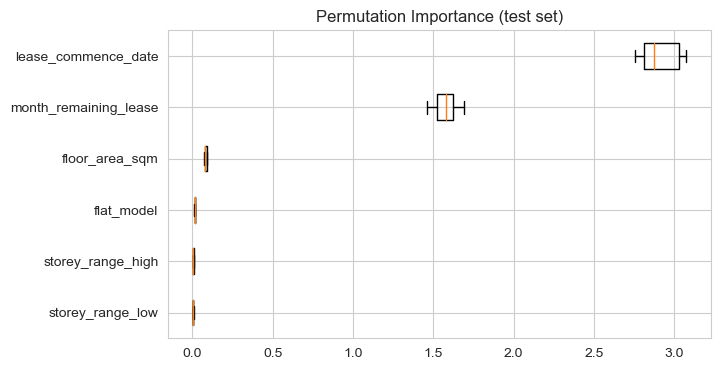

In [274]:
# Gradient Boosting Regressor
print(town, "-", flat_type)
gb_model = PredictionModel('GradientBoostingRegressor')
gb_model.train_model(df.copy(), town, flat_type)
gb_regressor = gb_model.fit()
y_pred = gb_model.predict(gb_regressor)
gb_model.evaluate(y_pred)
gb_model.plot_importance(gb_regressor)
gb_model.plot_permutation(gb_regressor)

## Possible Improvements to Be Made

1. Consider additional data columns that may possibly affect prices of flats
- Distance to nearest MRT station
- Distance to recreational buildings (e.g. Shopping malls, Community Centers, Parks)
- PSI of location
- Population in Singapore
- Cost of landed properties
- Cost of condominiums
- Cost of living in Singapore

1. Consider removal of outliers
- Removal of data affected by unexpected world affairs such as COVID